<a href="https://colab.research.google.com/github/qmeng222/MNIST-Playground/blob/main/autoencoder/encoder_decoder_latent_units.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task:

---
Perform a parametric experiment to explore how # encoder/decoder units and # latent units affects the loss.
- encoding/decoding units: 10~500 in 12 steps
- latent/bottleneck units: 5~100 in 8 steps
- 12x8=96 experiments
- train on mini batches without dataloader objects (loop through mini batches to sample the entire dataset)
- store the average 3 final losses from training
- print single-line progress report

In [1]:
import numpy as np

import torch
import torch.nn as nn # build model, loss func
import torch.nn.functional as F # activation func

import sys

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

In [2]:
# import dataset:
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',') # np array
print(data.shape)

# don't need labels, just extract data:
data   = data[:,1:]

# normalize the data to [0 1]:
dataNorm = data / np.max(data)

# np array -> torch tensor:
dataT = torch.tensor( dataNorm ).float() # torch tensor

(20000, 785)


In [3]:
def createTheMNISTAE(n_enc,n_bottle): # introduce variables for softcoding

  # create a class for the model:
  class aenet(nn.Module): # ae: autoencoder
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,n_enc)

      ### encoder layer
      self.encoding = nn.Linear(n_enc,n_bottle)

      ### bottleneck layer
      self.bottleneck = nn.Linear(n_bottle,n_enc)

      ### decoder layer
      self.decoding = nn.Linear(n_enc,784)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.encoding(x) )
      x = F.relu( self.bottleneck(x) )
      y = torch.sigmoid( self.decoding(x) ) # get the outputs in the same range as the normalized inputs
      return y

  # create an model instance:
  net = aenet()

  # loss function:
  lossfun = nn.MSELoss() # MSELoss for regression problem

  # optimizer:
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [4]:
# a function to train the model:
def function2trainTheModel(n_enc,n_bottle): # two variables -> double "for loop"

  net,lossfun,optimizer = createTheMNISTAE(n_enc,n_bottle)

  # initialize losses
  losses = []

  # batch size and #batches
  batchsize  = 32
  numBatches = int(dataT.shape[0]/batchsize)

  numepochs = 3
  for epochi in range(numepochs):

    # get a permuted index vector
    randidx = np.random.permutation(dataT.shape[0]).astype(int)
    # np.random.permutation(): generate a random array of values between 0 and the specified size (in this case, the number of rows in dataT)
    # np.random.permutation(10) -> array([1, 7, 4, 3, 0, 9, 2, 5, 8, 6]) # random
    # the elements are stored as floats
    # astype(int): convert the random values generated by the permutation() function into integers

    batchlosses = []

    for batchi in range(numBatches):

      samps2use = range((batchi-1)*batchsize,batchi*batchsize) # batch section
      X = dataT[randidx[samps2use],:] # select batch images

      # forward pass
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchlosses.append( loss.item() )
    # end minibatch loop

    losses.append( np.mean(batchlosses[-3:]) )
  # end epoch loop

  # function output:
  return losses,net

In [5]:
# run the expt!

# specific the number of units
N_encdec_units = np.linspace(10,500,12).astype(int) # np array
N_bottle_units = np.linspace(5,100,8).astype(int)

# initialize results matrix
exp_results = np.zeros((len(N_encdec_units),len(N_bottle_units)))

# start the experiment!
for ei,nenc in enumerate(N_encdec_units):
  for bi,nbot in enumerate(N_bottle_units):

    # build/train a model
    losses = function2trainTheModel(nenc,nbot)[0] # only need the first output (losses)
    exp_results[ei,bi] = np.mean(losses[-1]) # update results matrix

    # send update message
    currentIter = ei*len(N_bottle_units)+bi+1 # iteration number for the doulbe for loops
    totalIters  = len(N_bottle_units)*len(N_encdec_units) # 8x12=96
    msg = 'Finished experiment {}/{}'.format(currentIter,totalIters)
    sys.stdout.write('\r' + msg)

Finished experiment 96/96

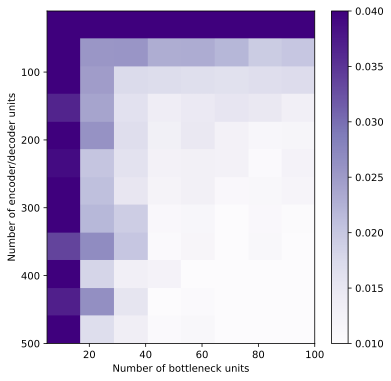

In [6]:
# show the results matrix:

fig = plt.figure(figsize=(6,6))

plt.imshow(exp_results,aspect='auto',         # data and aspect ratio
           vmin=.01,vmax=.04, cmap='Purples', # color range and palette
           extent=[ N_bottle_units[0],N_bottle_units[-1],N_encdec_units[-1],N_encdec_units[0], ]) # xy axis ticks

plt.xlabel('Number of bottleneck units')
plt.ylabel('Number of encoder/decoder units')
plt.colorbar()

plt.show()

👆 The more nodes in the bottleneck and encoder/decoder layers (less compression of the data), the more accurate the reconstruction is going to be.

⚠️ However on the other hand, the purpose of autoencoder is to have as small bottleneck as it reasoanbley can be!

✅ It's ultimately a trade off between accuracy and dimensionality reduction.

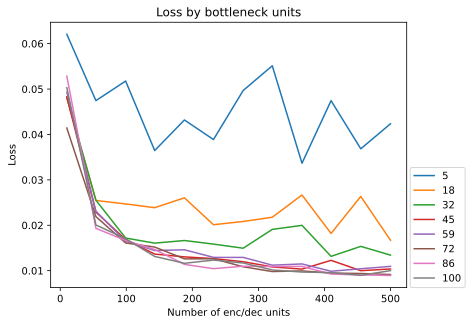

In [7]:
# a line plot will better reveal the sudden transition:

plt.plot(N_encdec_units,exp_results)
plt.legend(N_bottle_units,loc=(1.01,0))
plt.xlabel('Number of enc/dec units')
plt.title('Loss by bottleneck units')
plt.ylabel('Loss')
plt.show()